# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
%reload_ext watermark
%watermark --iversions --python

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

sklearn    : 1.3.0
statsmodels: 0.14.0
numpy      : 1.25.0
pandas     : 2.0.3
seaborn    : 0.12.2
patsy      : 0.5.3
matplotlib : 3.7.1



In [3]:
df = pd.read_csv('previsao_de_renda.csv')
df.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1, inplace=True)
df.dropna(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na base de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [5]:
# 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

df_train, df_test = train_test_split(df, train_size=0.75, random_state=0)

In [6]:
# 2. Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o R² na base de testes.
#    Qual o melhor modelo?
#    RESPOSTA: Não houve nenhuma alteração no R² e nem no AIC.


# FUNÇÕES (change_alpha, R_quadrado, stepwise_selection):
def change_alpha(formula, data, L1, alpha= 0):
    reg = smf.ols(formula, data= data).fit_regularized(method= 'elastic_net',
                                                       refit= True,
                                                       L1_wt= L1,
                                                       alpha= alpha)
    
    return reg

def R_quadrado(reg_texto, reg, df_test):
    
    if 'renda' in df_test:
        df_test['log_renda'] = np.log(df_test['renda'])
    else:
        None
    
    df_test['pred_'+reg_texto] = reg.predict(df_test)

    R_quadrado = df_test[['log_renda', 'pred_'+reg_texto]].corr().iloc[0,1]**2
    
    return R_quadrado

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [7]:
formula1 = '''np.log(renda) ~ sexo
                                 + posse_de_veiculo
                                 + C(posse_de_imovel, Treatment(1))
                                 + qtd_filhos
                                 + tipo_renda
                                 + C(educacao, Treatment(2))
                                 + estado_civil
                                 + C(tipo_residencia, Treatment(1))
                                 + idade
                                 + tempo_emprego
                                 + qt_pessoas_residencia
           '''

In [8]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0] e avalie o R² na base de testes.
#    alpha= 0:

reg1 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0)

print('\n'+'#'*120+'\n# ALPHA=0 #\n'+'#'*11+f'{reg1.summary()}')


########################################################################################################################
# ALPHA=0 #
###########                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:13   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coef    s

In [9]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0.001] e avalie o R² na base de testes.
#    alpha= 0.001:

reg2 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0.001)

print('\n'+'#'*120+'\n# ALPHA=0.001 #\n'+'#'*15+f'{reg2.summary()}')


########################################################################################################################
# ALPHA=0.001 #
###############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:14   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        c

In [10]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0.005] e avalie o R² na base de testes.
#    alpha= 0.005:

reg3 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0.005)

print('\n'+'#'*120+'\n# ALPHA=0.005 #\n'+'#'*15+f'{reg3.summary()}')


########################################################################################################################
# ALPHA=0.005 #
###############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:14   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        c

In [11]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0.01] e avalie o R² na base de testes.
#    alpha= 0.01:

reg4 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0.01)

print('\n'+'#'*120+'\n# ALPHA=0.01 #\n'+'#'*14+f'{reg4.summary()}')


########################################################################################################################
# ALPHA=0.01 #
##############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:15   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coe

In [12]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0.05] e avalie o R² na base de testes.
#    alpha= 0.05:

reg5 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0.05)

print('\n'+'#'*120+'\n# ALPHA=0.05 #\n'+'#'*14+f'{reg5.summary()}')


########################################################################################################################
# ALPHA=0.05 #
##############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:16   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coe

In [13]:
# 2. Rode uma regularização ridge (L1=0.00001) com alpha=[0.1] e avalie o R² na base de testes.
#    alpha= 0.1:

reg6 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 0.00001,
                    alpha= 0.1)

print('\n'+'#'*120+'\n# ALPHA=0.1 #\n'+'#'*13+f'{reg6.summary()}')


########################################################################################################################
# ALPHA=0.1 #
#############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:16   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coef 

In [14]:
# 2. Avalie o R² na base de testes.
#    Qual o melhor modelo?
#    RESPOSTA: Não houve nenhuma alteração no R².

print(f'\nR² para ALPHA=0:      {R_quadrado("reg1",reg1, df_test)}')
print(f'\nR² para ALPHA=0.001:  {R_quadrado("reg2",reg2, df_test)}')
print(f'\nR² para ALPHA=0.005:  {R_quadrado("reg3",reg3, df_test)}')
print(f'\nR² para ALPHA=0.01:   {R_quadrado("reg4",reg4, df_test)}')
print(f'\nR² para ALPHA=0.05:   {R_quadrado("reg5",reg5, df_test)}')
print(f'\nR² para ALPHA=0.1:    {R_quadrado("reg6",reg6, df_test)}')


R² para ALPHA=0:      0.3601469972007737

R² para ALPHA=0.001:  0.3601469972007737

R² para ALPHA=0.005:  0.3601469972007737

R² para ALPHA=0.01:   0.3601469972007737

R² para ALPHA=0.05:   0.3601469972007737

R² para ALPHA=0.1:    0.3601469972007737


In [15]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO. Qual método chega a um melhor resultado?
#    Resposta: A Regressão LASSO é bem melhor.
#              O método e modelo com melhor resultado foi a da Regressão LASSO modelo com alpha=0.01.
#              Em que foram retiradas as variáveis com P-value > 0.05.
#    alpha= 0:

reg7 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 1,
                    alpha= 0)

print('\n'+'#'*120+'\n# ALPHA=0 #\n'+'#'*11+f'{reg7.summary()}')


########################################################################################################################
# ALPHA=0 #
###########                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     205.6
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:17   Log-Likelihood:                -10181.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9295   BIC:                         2.060e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                        coef    s

In [16]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO.
#    alpha= 0.001:

reg8 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 1,
                    alpha= 0.001)

print('\n'+'#'*15+'\n# ALPHA=0.001 #\n'+'#'*15+f'{reg8.summary()}')


###############
# ALPHA=0.001 #
###############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     321.0
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:18   Log-Likelihood:                -10184.
No. Observations:                9320   AIC:                         2.040e+04
Df Residuals:                    9304   BIC:                         2.052e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [17]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO.
#    alpha= 0.005:

reg9 = change_alpha(formula= formula1,
                    data= df_train,
                    L1= 1,
                    alpha= 0.005)

print('\n'+'#'*15+'\n# ALPHA=0.005 #\n'+'#'*15+f'{reg9.summary()}')


###############
# ALPHA=0.005 #
###############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     544.2
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:18   Log-Likelihood:                -10263.
No. Observations:                9320   AIC:                         2.055e+04
Df Residuals:                    9311   BIC:                         2.062e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [18]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO.
#    alpha= 0.01:

reg10 = change_alpha(formula= formula1,
                     data= df_train,
                     L1= 1,
                     alpha= 0.01)

print('\n'+'#'*14+'\n# ALPHA=0.01 #\n'+'#'*14+f'{reg10.summary()}')


##############
# ALPHA=0.01 #
##############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     973.3
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:19   Log-Likelihood:                -10274.
No. Observations:                9320   AIC:                         2.056e+04
Df Residuals:                    9315   BIC:                         2.060e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [19]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO.
#    alpha= 0.05:

reg11 = change_alpha(formula= formula1,
                     data= df_train,
                     L1= 1,
                     alpha= 0.05)

print('\n'+'#'*14+'\n# ALPHA=0.05 #\n'+'#'*14+f'{reg11.summary()}')


##############
# ALPHA=0.05 #
##############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     1206.
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:19   Log-Likelihood:                -10288.
No. Observations:                9320   AIC:                         2.059e+04
Df Residuals:                    9316   BIC:                         2.062e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [20]:
# 3. Faça o mesmo que no passo 2 (L1=1), com uma regressão LASSO.
#    alpha= 0.1:

reg12 = change_alpha(formula= formula1,
                     data= df_train,
                     L1= 1,
                     alpha= 0.1)

print('\n'+'#'*13+'\n# ALPHA=0.1 #\n'+'#'*13+f'{reg12.summary()}')


#############
# ALPHA=0.1 #
#############                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     1206.
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:19   Log-Likelihood:                -10288.
No. Observations:                9320   AIC:                         2.059e+04
Df Residuals:                    9316   BIC:                         2.062e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [21]:
print(f'\nR² para ALPHA=0:      {R_quadrado("reg7",reg7, df_test)}')
print(f'\nR² para ALPHA=0.001:  {R_quadrado("reg8",reg8, df_test)}')
print(f'\nR² para ALPHA=0.005:  {R_quadrado("reg9",reg9, df_test)}')
print(f'\nR² para ALPHA=0.01:   {R_quadrado("reg10",reg10, df_test)}')
print(f'\nR² para ALPHA=0.05:   {R_quadrado("reg11",reg11, df_test)}')
print(f'\nR² para ALPHA=0.1:    {R_quadrado("reg12",reg12, df_test)}')


R² para ALPHA=0:      0.3601469972007737

R² para ALPHA=0.001:  0.36017518304704954

R² para ALPHA=0.005:  0.35192046369512553

R² para ALPHA=0.01:   0.3512008036138978

R² para ALPHA=0.05:   0.3480551890088389

R² para ALPHA=0.1:    0.3480551890088389


In [22]:
df_dummies = pd.get_dummies(df,
                            columns=['sexo',
                                     'posse_de_veiculo',
                                     'posse_de_imovel',
                                     'tipo_renda',
                                     'educacao',
                                     'estado_civil',
                                     'tipo_residencia'],
                            drop_first=True).astype('float')

df_dummies.rename(columns={'tipo_renda_Servidor público':'tipo_renda_Servidor_público',
                           'educacao_Pós graduação':'educacao_Pós_graduação',
                           'educacao_Superior completo': 'educacao_Superior_completo',
                           'educacao_Superior incompleto':'educacao_Superior_incompleto',
                           'tipo_residencia_Com os pais': 'tipo_residencia_Com_os_pais'}, inplace=True)

df_dummies['log_renda'] = np.log(df_dummies['renda'])
df_dummies.drop(['renda'], axis=1, inplace=True)

X = df_dummies.drop(columns=['log_renda'])

y = df_dummies['log_renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

df_train_dummies, df_test_dummies = train_test_split(df_dummies, train_size=0.75, random_state=0)

In [23]:
variaveis = stepwise_selection(X_train, y_train)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 0.0
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 4.85844e-18
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  educacao_Superior_completo     with p-value 8.37721e-12
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior_completo']
Add  idade                          with p-value 2.52769e-12
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior_completo', 'idade']
Add  posse_de_imovel_True           with p-value 7.34663e-07
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior_completo', 'idade', 'posse_de_imovel_True']
Add  qtd_filhos                     with p-value 0.000135216
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior_completo', 'idade', 'posse_de

In [24]:
formula2 = '''log_renda ~  tempo_emprego
                                    + sexo_M
                                    + tipo_renda_Empresário
                                    + educacao_Superior_completo
                                    + idade
                                    + posse_de_imovel_True
                                    + qtd_filhos
                                    + tipo_renda_Servidor_público
                                    + estado_civil_União
                                    + posse_de_veiculo_True
           '''

In [25]:
# 4. Rode um modelo stepwise. Avalie o R² na base de testes. Qual o melhor resultado?

modelo_stepwise = smf.ols(formula= formula2,
                          data= df_train_dummies).fit()
modelo_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     511.2
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:21   Log-Likelihood:                -10193.
No. Observations:                9320   AIC:                         2.041e+04
Df Residuals:                    9309   BIC:                         2.049e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.0794      0.041    172.760      0.000       6.999       7.160
tempo_emprego                   0.0615      0.001     51.355      0.000       0.059       0.064
sexo_M                          0.7824      0.017     46.717      0.000       0.750       0.815
tipo_renda_Empresário           0.1535      0.017      8.908      0.000       0.120       0.187
educacao_Superior_completo      0.1063      0.016      6.771      0.000       0.076       0.137
idade                           0.0064      0.001      7.221      0.000       0.005       0.008
posse_de_imovel_True            0.0755      0.016      4.751      0.000       0.044       0.107
qtd_filhos                      0.0366      0.010      3.649      0.000       0.017       0.056
tipo_renda_Servidor_público     0.0662      0.026      2.587      0.010       0.016       0.116
estado_civil_União             -0.0618      0.029     -2.147      0.032      -0.118      -0.005
posse_de_veiculo_True           0.0346      0.016      2.139      0.032       0.003       0.066
==============================================================================
Omnibus:                        0.320   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.293
Skew:                           0.010   Prob(JB):                        0.864
Kurtosis:                       3.018   Cond. No.                         240.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# 4. Rode um modelo stepwise. Avalie o R² na base de testes. Qual o melhor resultado?
# 5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
#    Resposta: Analisando o P-values de todos os resultados, chegamos a conclusão que os 2 melhores resultados
#              são esses, respectivamente:

print(f'''\n1- R² para ALPHA=0 (modelo_stepwise): {R_quadrado('modelo_stepwise', modelo_stepwise, df_test_dummies)}''')

print(f'\n2- R² para ALPHA=0.01 e L1= 1:        {R_quadrado("reg10",reg10, df_test)}')


1- R² para ALPHA=0 (modelo_stepwise): 0.3611641809250814

2- R² para ALPHA=0.01 e L1= 1:        0.3512008036138978


In [27]:
formula3 = '''log_renda ~  tempo_emprego
                                    + sexo_M
                                    + tipo_renda_Empresário
                                    + educacao_Superior_completo
                                    + idade
                                    + posse_de_imovel_True
                                    + qtd_filhos
                                    + tipo_renda_Servidor_público
           '''

In [28]:
# 6. Partindo dos modelos que você ajustou, tente melhorar o R² na base de testes.
#    Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
#    Resposta: Conseguimos retirar duas variáveis sem nenhuma perda no R² e nenhum aumento no AIC.
#              As variáveis retiradas foram: 'estado_civil_União' e 'posse_de_veiculo_True'.

modelo_stepwise2 = change_alpha(formula= formula3,
                                data= df_train_dummies,
                                L1= 1)

print(f'''\n1- R² para ALPHA=0 (modelo_stepwise2): {R_quadrado('modelo_stepwise2', modelo_stepwise2, df_test_dummies)}''')

modelo_stepwise2.summary()


1- R² para ALPHA=0 (modelo_stepwise2): 0.36098780873774045


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     566.4
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:12:21   Log-Likelihood:                -10198.
No. Observations:                9320   AIC:                         2.042e+04
Df Residuals:                    9311   BIC:                         2.049e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.0792      0.040    175.880      0.000       7.000       7.158
tempo_emprego                   0.0615      0.001     51.296      0.000       0.059       0.064
sexo_M                          0.7954      0.016     50.149      0.000       0.764       0.827
tipo_renda_Empresário           0.1533      0.017      8.895      0.000       0.120       0.187
educacao_Superior_completo      0.1094      0.016      6.986      0.000       0.079       0.140
idade                           0.0065      0.001      7.326      0.000       0.005       0.008
posse_de_imovel_True            0.0774      0.016      4.867      0.000       0.046       0.109
qtd_filhos                      0.0381      0.010      3.797      0.000       0.018       0.058
tipo_renda_Servidor_público     0.0666      0.026      2.604      0.009       0.016       0.117
==============================================================================
Omnibus:                        0.296   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.270
Skew:                           0.010   Prob(JB):                        0.874
Kurtosis:                       3.017   Cond. No.                         234.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

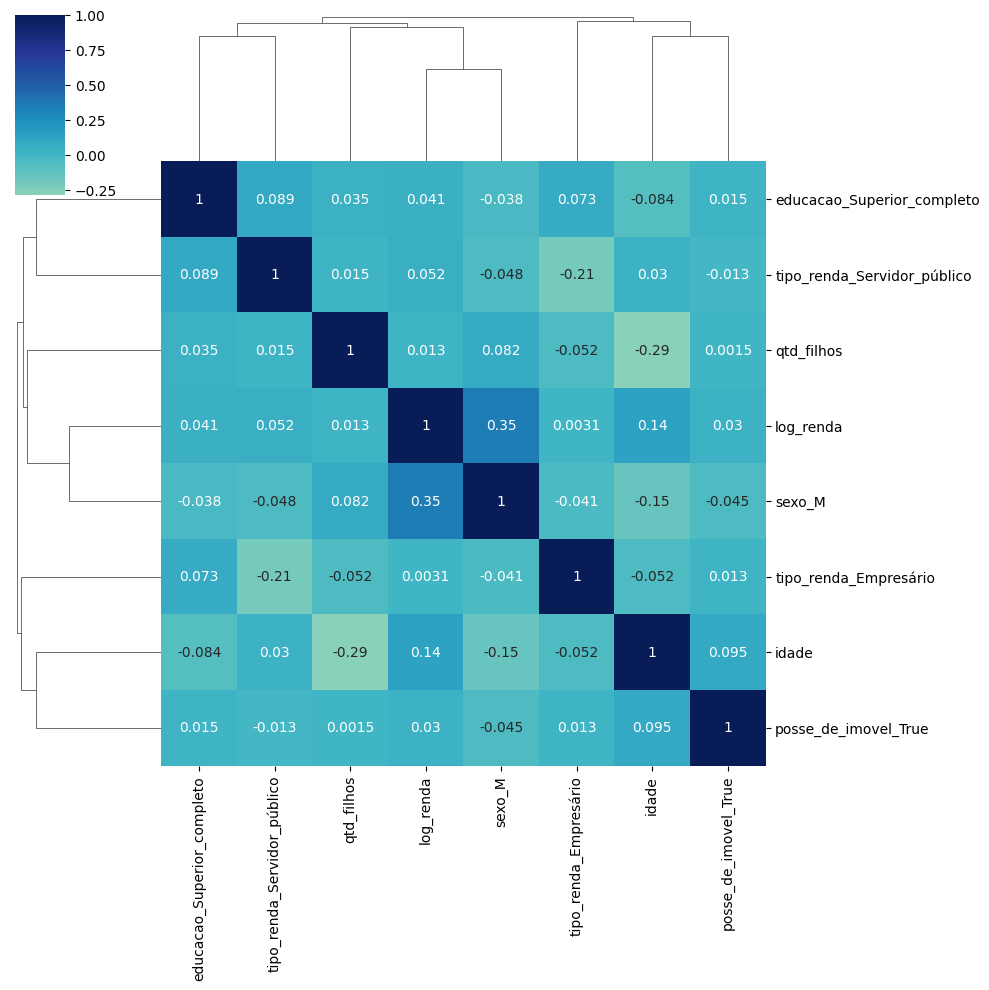

In [29]:
# 7. Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.
#    Clustermap para avalisar as correlação entre as variáveis.

sns.clustermap(data= df_train_dummies[['log_renda',
                                       'sexo_M',
                                       'tipo_renda_Empresário',
                                       'educacao_Superior_completo', 
                                       'idade',
                                       'posse_de_imovel_True',
                                       'qtd_filhos',
                                       'tipo_renda_Servidor_público']].corr(),
               figsize= (10, 10),
               center = 0,
               annot= True,
               cmap= "YlGnBu")

<Axes: xlabel='n_minimo', ylabel='profundidade'>

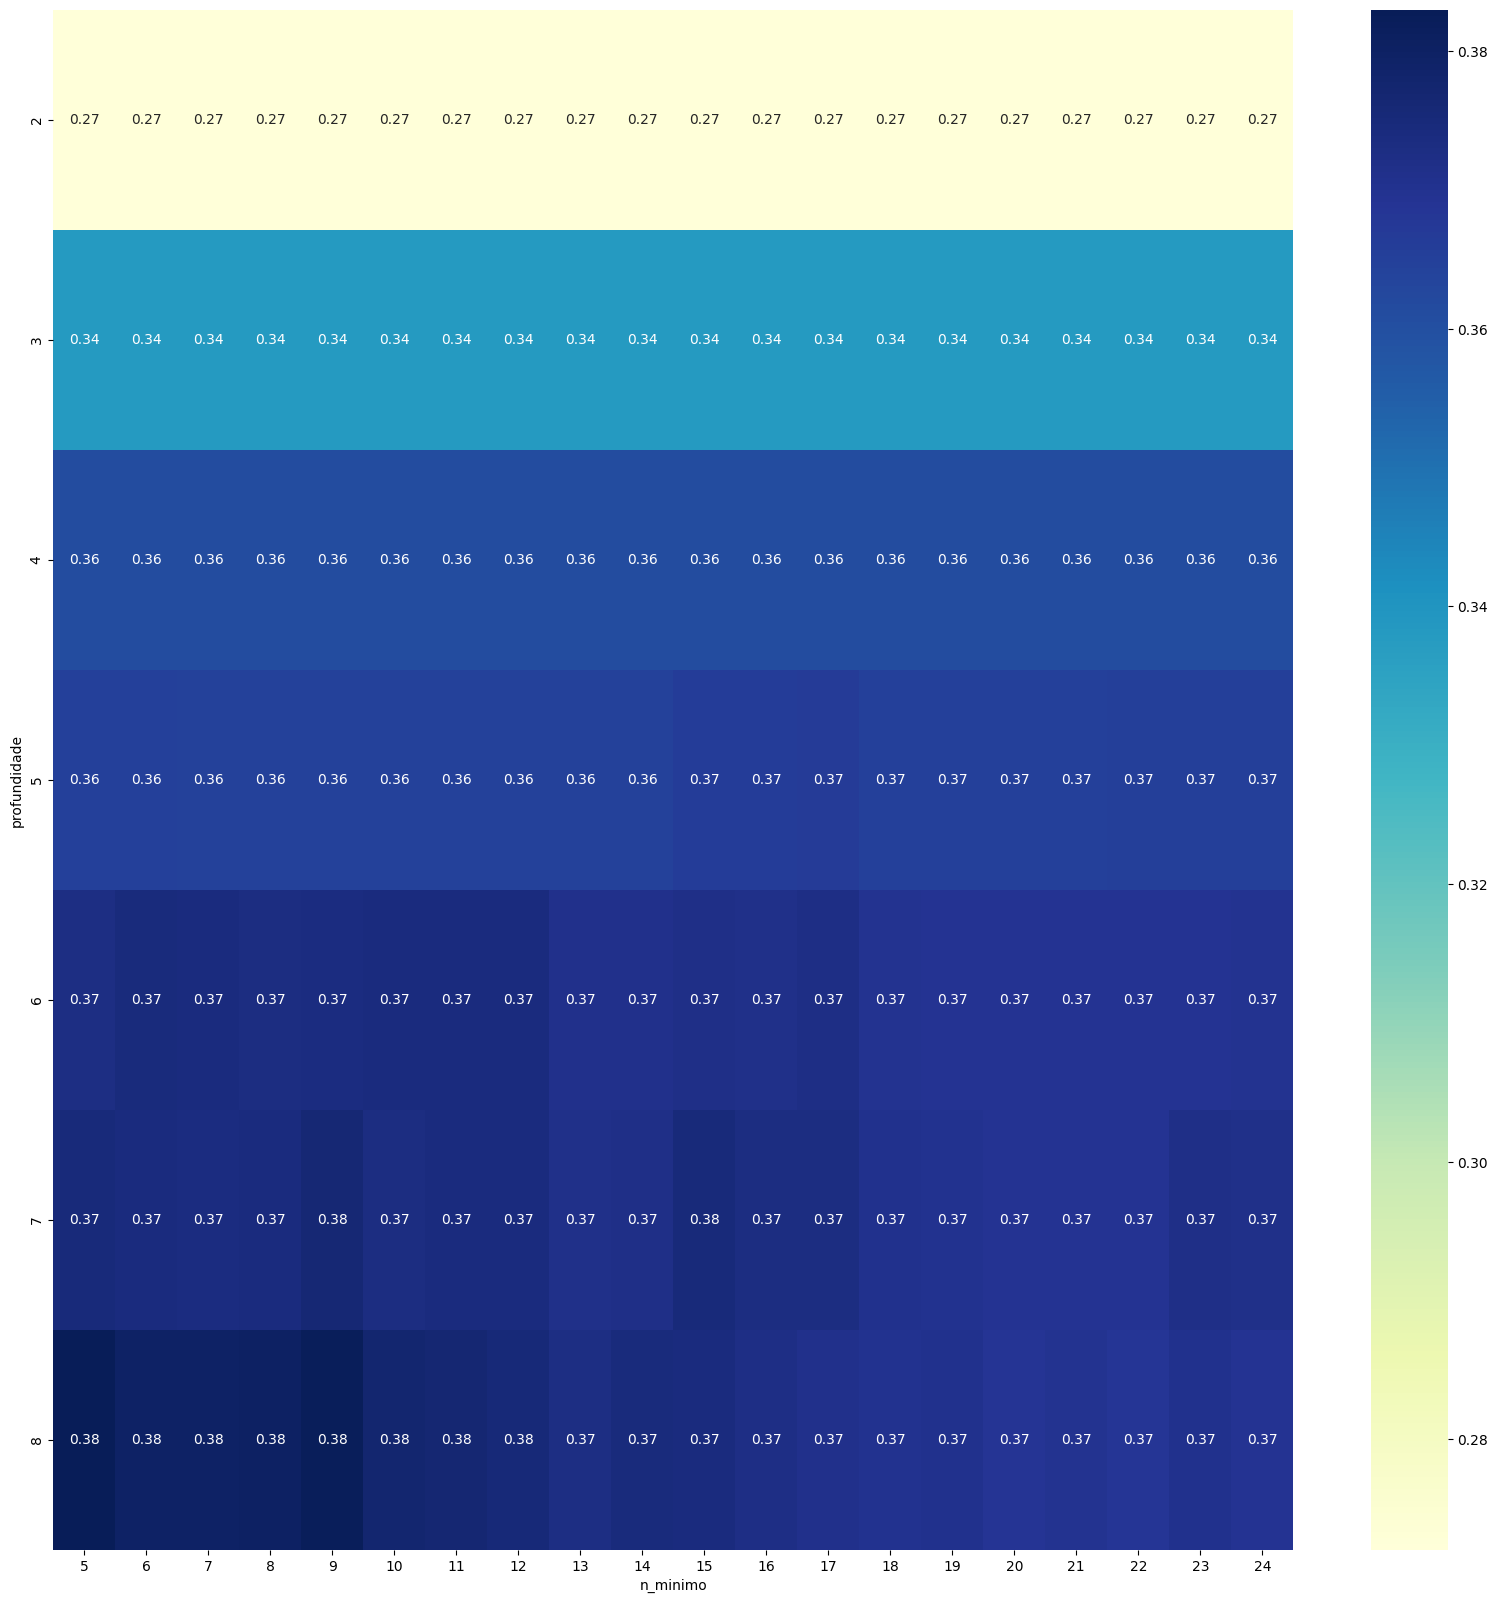

In [30]:
# 7. Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.
#    Avaliando a melhor profundidade e número minímo de folhas da Árvore.

mses = []
ind_i = []
ind_j = []

for i in range (2, 9):
    for j in range(5,25):
        reg13 = DecisionTreeRegressor(max_depth=i,min_samples_leaf=j).fit(X_train, y_train)
        mse1 = reg13.score(X_test, y_test)
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)

df_mse = pd.DataFrame({'mses': mses, 'profundidade': ind_i, 'n_minimo': ind_j})
plt.figure(figsize=(20,20))
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'), annot=True, cmap= "YlGnBu")

In [31]:
# 7. Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.
# Criando um modelo de regressão com profundidade= 7 e número minímo de folhas= 9.

reg13 = DecisionTreeRegressor(max_depth=7,min_samples_leaf=9).fit(X_train, y_train)
print("1- R² do modelo reg13(max_depth=7, \n                   nmin_samples_leaf=9): %.7f" % reg13.score(X_test, y_test))
print(f'''\n2- R² do modelo_stepwise:                {R_quadrado('modelo_stepwise', modelo_stepwise, df_test_dummies):.7f}''')
print(f'''\n3- R² do modelo_stepwise2:               {R_quadrado('modelo_stepwise2', modelo_stepwise2, df_test_dummies):.7f}''')

1- R² do modelo reg13(max_depth=7, 
                   nmin_samples_leaf=9): 0.3761725

2- R² do modelo_stepwise:                0.3611642

3- R² do modelo_stepwise2:               0.3609878


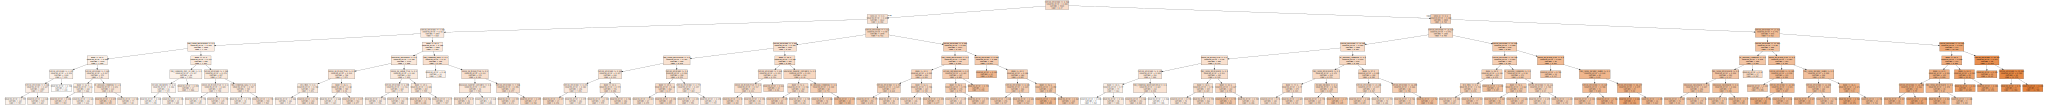

In [32]:
# 7. Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.
#    Resposta: Conseguimos um R² melhor, porém a profundidade ficou relativamente grande,
#              talvez a melhor opção seria uma profundidade menor em que o R² não sofra grandes alterações.

import graphviz

dot_data = tree.export_graphviz(reg13, out_file=None,
                               feature_names=list(X.columns),
                               filled=True)

graphviz.Source(dot_data, format='png')